# DDPLKO Moduł 6 - praca domowa - Data augmentation

To szósta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Na bazie ostatniej pracy domowej z Transfer learningiem
- [ ] Dobierz Data augmentation do zbioru danych, tak aby generowane zdjęcia były podobne do zbioru Val
- [ ] Wyświetl przykłady przed i po data augmentation
- [ ] Wykonaj trening klasyfikatora oraz całej sieci (fine tuning) wykorzystując data augmentation
- [ ] Przygotuj wykres w którym porównasz 2 treningi - bez data augmentation i z data augmentation
- [ ] Udostępnij wykres na Discordzie `#klasyfikacja-wyniki` (val acc)

Możesz (czyli opcjonalne rzeczy):
- wykonać tylko trening klasyfikatora, bez fine tuningu, jeżeli masz ograniczone zasoby
- zwizualizować dodatkowo i wskazać zmiany:
  - confussion matrix - gdzie jest lepiej, gdzie gorzej
  - błędne przypadki - które próbki już są poprawnie klasyfikowane, a które przestały być

## Wczytywanie danych z poprzedniego modułu

In [1]:
# z lekcji 5.04

import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import models, datasets
from torchvision import transforms as T
from torch import nn
import torch

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.callbacks import EarlyStopping

#!pip install timm
import timm

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
(ds_train, ds_val),info = tfds.load(
    "resisc45",
    split=["train[:70%]", "train[70%:100%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print('Train:',len(ds_train))
print('Val:',len(ds_val))

Train: 22050
Val: 9450


In [3]:
class_names = info.features['label'].names
for c in class_names:
    print(c)

airplane
airport
baseball_diamond
basketball_court
beach
bridge
chaparral
church
circular_farmland
cloud
commercial_area
dense_residential
desert
forest
freeway
golf_course
ground_track_field
harbor
industrial_area
intersection
island
lake
meadow
medium_residential
mobile_home_park
mountain
overpass
palace
parking_lot
railway
railway_station
rectangular_farmland
river
roundabout
runway
sea_ice
ship
snowberg
sparse_residential
stadium
storage_tank
tennis_court
terrace
thermal_power_station
wetland


In [4]:
num_classes = len(class_names)
num_classes

45

2 (256, 256, 3) tf.Tensor(11, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(27, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(15, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(41, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(34, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(1, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(6, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(7, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(8, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(15, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(25, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(26, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(22, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(27, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(44, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(39, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(31, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(37, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(9, shape=(), dtype=int64

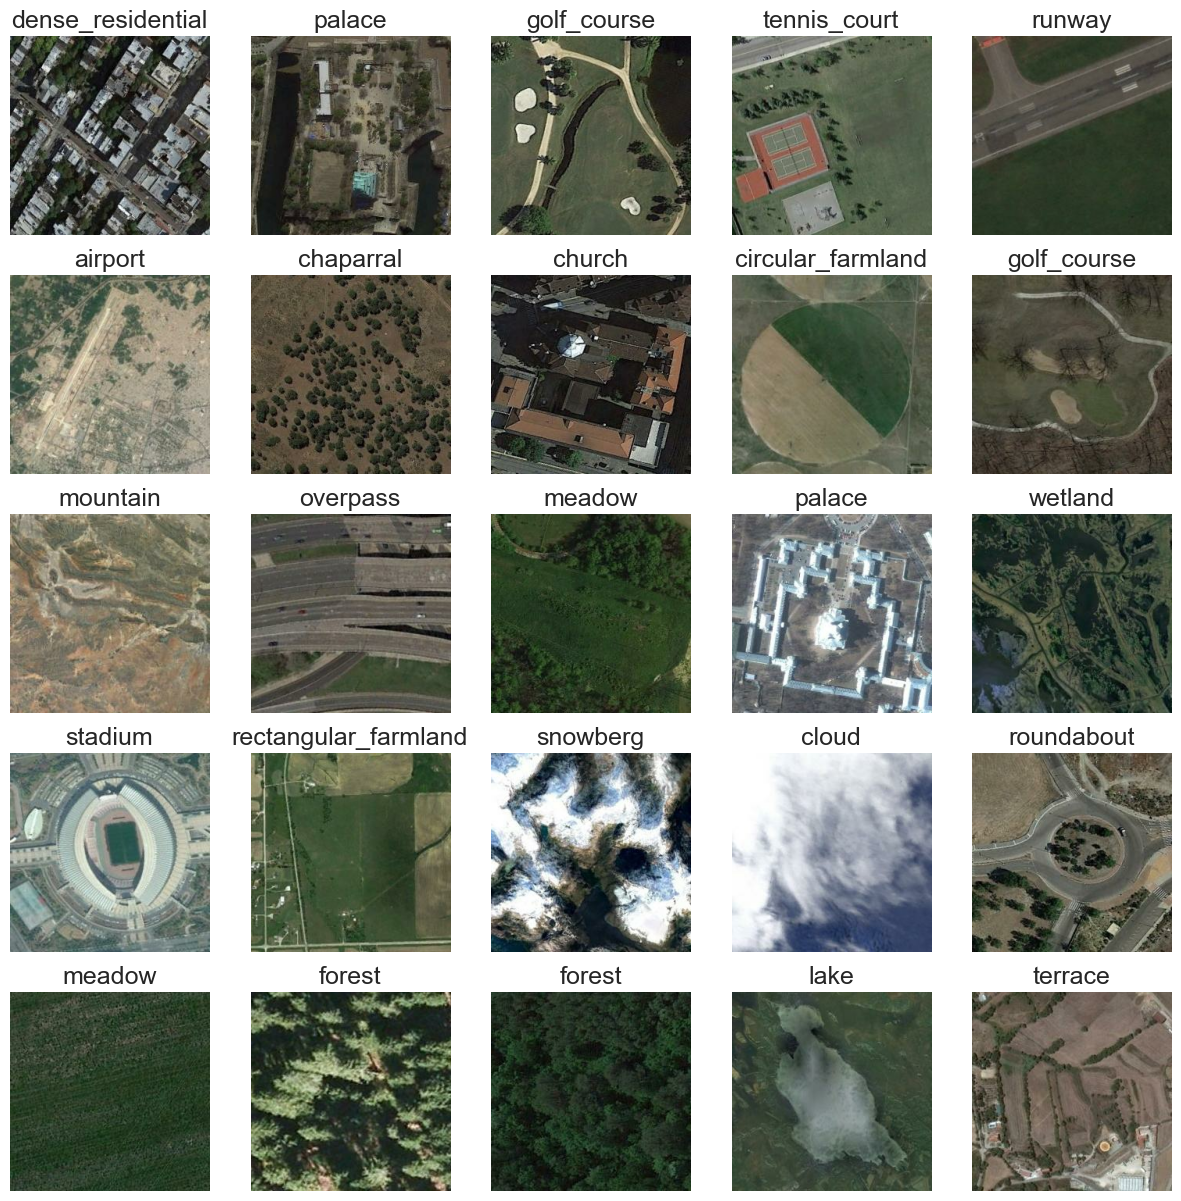

In [5]:
plt.figure(figsize=(15,15))
for i,_ in enumerate(ds_train.take(25)):
    print(len(_),_[0].shape,_[1])
    plt.subplot(5,5,i+1)
    plt.imshow(_[0])
    plt.title(class_names[_[1]])
    plt.axis('off')
plt.show()

# Data augmentation

In [6]:
# data augumentation do popkazania wizualizacji
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomContrast(factor=0.2),
                                         tf.keras.layers.RandomRotation(factor=0.1), # procent; zakres rotacji to: [-factor * 2pi, factor * 2pi]
                                         tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomFlip('vertical'),
                                         tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
                                         tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.2)
                                        ])
                                        

## Data augmentation - examples

2 (256, 256, 3) tf.Tensor(11, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(27, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(15, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(41, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(34, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(1, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(6, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(7, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(8, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(15, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(25, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(26, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(22, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(27, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(44, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(39, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(31, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(37, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(9, shape=(), dtype=int64

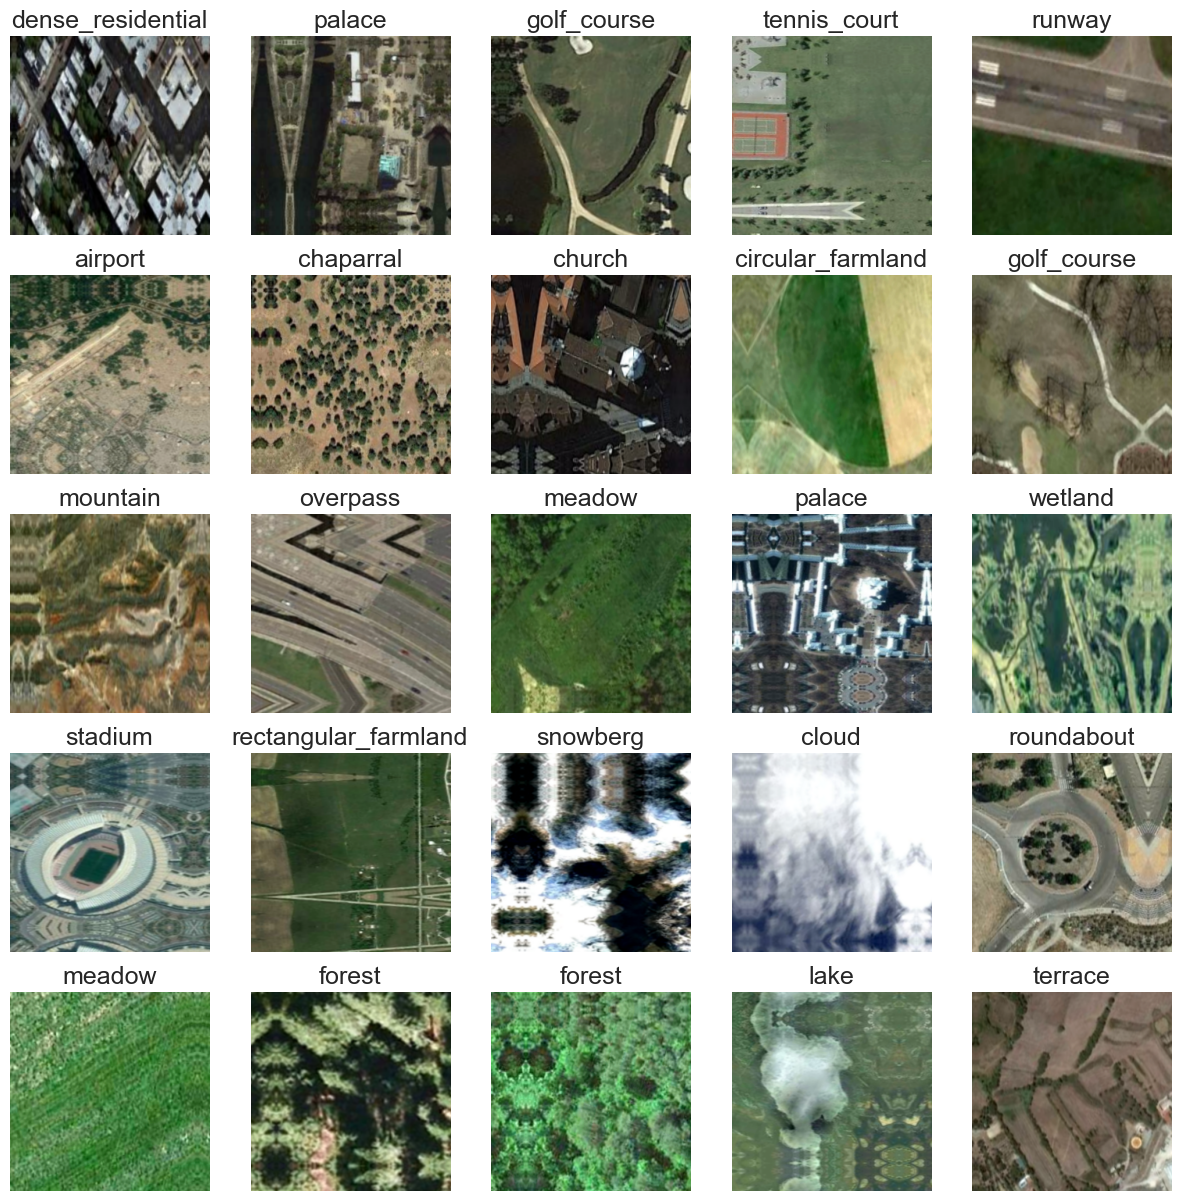

In [7]:
plt.figure(figsize=(15,15))
for i,_ in enumerate(ds_train.take(25)):
    print(len(_),_[0].shape,_[1])
    plt.subplot(5,5,i+1)
    aug = data_augmentation(_[0])
    plt.imshow((aug-np.min(aug))/(np.max(aug)-np.min(aug)))
    plt.title(class_names[_[1]])
    plt.axis('off')
plt.show()

In [8]:
# bez tej komórki model z augumentacją się wywala

img_size = 224
batch_size=32

size = (img_size, img_size)

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = ds_val.batch(batch_size=batch_size, drop_remainder=True)

In [9]:
# powtorzyłam drugi raz po po podzieleniu zbioru, gdyż model z augumentacją się wywala

data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomContrast(factor=0.2),
                                         tf.keras.layers.RandomRotation(factor=0.1), # procent; zakres rotacji to: [-factor * 2pi, factor * 2pi]
                                         tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomFlip('vertical'),
                                         tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
                                         tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.2)
                                        ], name="data_augmentation")                                                                          
                                


## Fine tuning with augmentation

# No augmentation vs augmentation

In [10]:
def tuned_model(img_size,num_classes, data_augmentation=None):
    layers =[tf.keras.layers.Input(shape=(img_size, img_size, 3))]
          
    if data_augmentation is not None:
        layers.append(data_augmentation)
        
              
    base_model = tf.keras.applications.EfficientNetB0(include_top=False,  weights="imagenet")
    base_model.trainable = True
    
    layers.append(base_model)
    layers.append(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"))
    
    layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Dropout(0.02, name="top_dropout"))
    layers.append(tf.keras.layers.Dense(num_classes, activation="softmax", name="pred"))

    model = tf.keras.Sequential(layers)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [11]:
model = tuned_model(img_size=img_size, num_classes=len(class_names))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
pred (Dense)                 (None, 45)                57645     
Total params: 4,112,336
Trainable params: 4,067,753
Non-trainable params: 44,583
_________________________________________________________________


In [12]:
epochs = 30
batch_size = 32

In [13]:
model_aug = tuned_model(img_size=img_size, num_classes=len(class_names), data_augmentation=data_augmentation)
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
pred (Dense)                 (None, 45)                57645     
Total params: 4,112,336
Trainable params: 4,067,753
Non-trainable params: 44,583
_______________________________________

In [14]:
history_tuned = model_aug.fit(ds_train, epochs=epochs, validation_data=ds_val, verbose=1)

Epoch 1/30
689/689 [==============================] - 1874s 3s/step - loss: 3.8718 - accuracy: 0.1004 - val_loss: 3.0710 - val_accuracy: 0.2197
Epoch 2/30
689/689 [==============================] - 1896s 3s/step - loss: 2.5315 - accuracy: 0.3397 - val_loss: 2.0795 - val_accuracy: 0.4418
Epoch 3/30
689/689 [==============================] - 1903s 3s/step - loss: 1.7789 - accuracy: 0.5152 - val_loss: 1.4593 - val_accuracy: 0.6026
Epoch 4/30
689/689 [==============================] - 1899s 3s/step - loss: 1.3525 - accuracy: 0.6281 - val_loss: 1.0885 - val_accuracy: 0.6982
Epoch 5/30
689/689 [==============================] - 1909s 3s/step - loss: 1.0926 - accuracy: 0.6902 - val_loss: 0.8614 - val_accuracy: 0.7573
Epoch 6/30
689/689 [==============================] - 1883s 3s/step - loss: 0.9226 - accuracy: 0.7384 - val_loss: 0.7176 - val_accuracy: 0.7910
Epoch 7/30
689/689 [==============================] - 1883s 3s/step - loss: 0.8080 - accuracy: 0.7683 - val_loss: 0.6194 - val_accuracy:

In [15]:
history_tuned_no = model.fit(ds_train, epochs=epochs, validation_data=ds_val, verbose=1)

Epoch 1/30
689/689 [==============================] - 1827s 3s/step - loss: 3.4860 - accuracy: 0.1588 - val_loss: 2.3899 - val_accuracy: 0.3779
Epoch 2/30
689/689 [==============================] - 1824s 3s/step - loss: 1.9024 - accuracy: 0.5017 - val_loss: 1.3748 - val_accuracy: 0.6338
Epoch 3/30
689/689 [==============================] - 1815s 3s/step - loss: 1.1991 - accuracy: 0.6823 - val_loss: 0.9324 - val_accuracy: 0.7500
Epoch 4/30
689/689 [==============================] - 1824s 3s/step - loss: 0.8522 - accuracy: 0.7748 - val_loss: 0.7025 - val_accuracy: 0.8069
Epoch 5/30
689/689 [==============================] - 1819s 3s/step - loss: 0.6478 - accuracy: 0.8258 - val_loss: 0.5702 - val_accuracy: 0.8395
Epoch 6/30
689/689 [==============================] - 1822s 3s/step - loss: 0.5131 - accuracy: 0.8625 - val_loss: 0.4847 - val_accuracy: 0.8638
Epoch 7/30
689/689 [==============================] - 1822s 3s/step - loss: 0.4156 - accuracy: 0.8879 - val_loss: 0.4250 - val_accuracy:

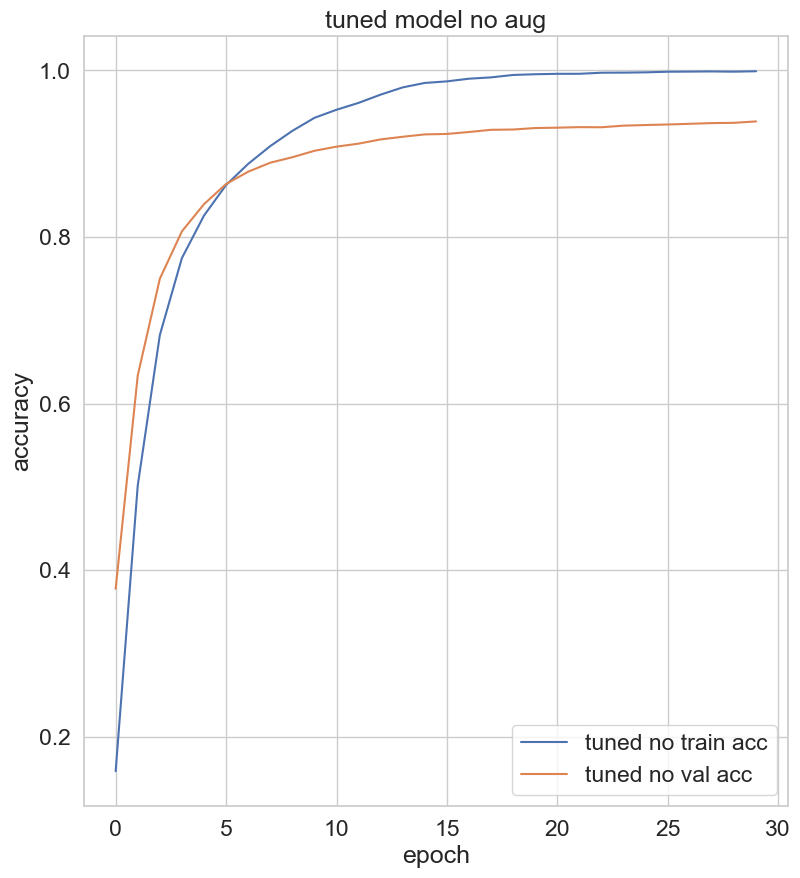

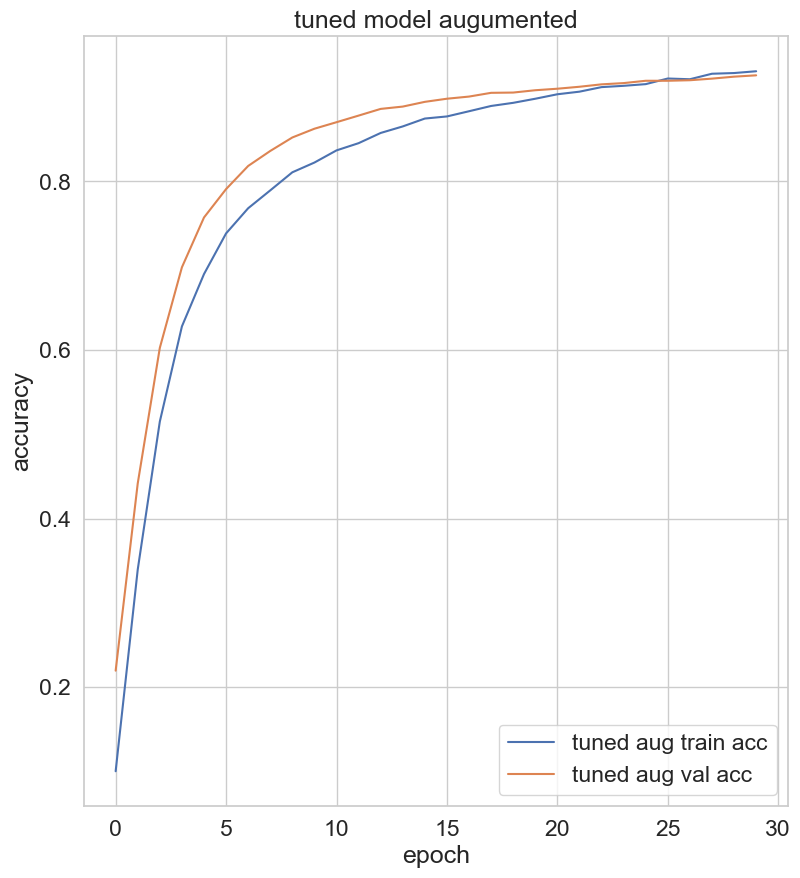

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(history_tuned_no.history["accuracy"], label='tuned no train acc')
plt.plot(history_tuned_no.history["val_accuracy"], label='tuned no val acc')
plt.title("tuned model no aug")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show();

plt.figure(figsize=(20,10))
plt.subplot(122)
plt.plot(history_tuned.history["accuracy"], label='tuned aug train acc')
plt.plot(history_tuned.history["val_accuracy"], label='tuned aug val acc')
plt.title("tuned model augumented")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show();

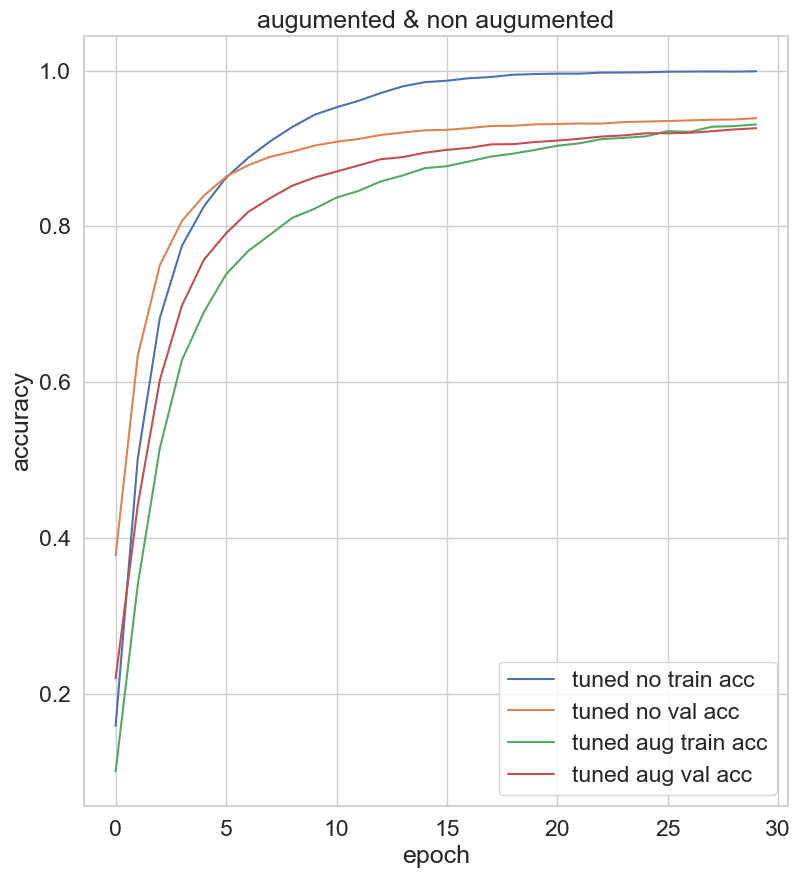

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(history_tuned_no.history["accuracy"], label='tuned no train acc')
plt.plot(history_tuned_no.history["val_accuracy"], label='tuned no val acc')
plt.title("augumented & non augumented")
plt.ylabel("accuracy")
plt.xlabel("epoch")

plt.plot(history_tuned.history["accuracy"], label='tuned aug train acc')
plt.plot(history_tuned.history["val_accuracy"], label='tuned aug val acc')

plt.legend()
plt.show();
